<a href="https://colab.research.google.com/github/Yusol88/HW_1/blob/master/Test_urbangeo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Алгоритм автоматической застройки участка

**Описание задачи:**

- На вход подаются:
  - Границы участка в формате GeoJSON (FeatureCollection с Polygon).
  - Ограничения по плотности застройки (процент от площади, допустимый для застройки).
  - Минимальное расстояние между объектами (например, 10 метров).
  - Дополнительные ограничения – наличие дорог, лесов, водоёмов, на которых нельзя строить (также в GeoJSON).

- На выходе:
  - GeoJSON-файл с информацией об объектах (здания, дороги, парки).
  - Изображение плана участка (например, .png).

**Используемые библиотеки:** `json`, `geopandas`, `shapely`, `matplotlib`, `random`.

In [ ]:
!pip install

In [4]:
# Импорт необходимых библиотек
import json
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape, Polygon, box
from shapely.ops import unary_union
import random

## Задание входных параметров

Зададим следующие параметры:
- **DENSITY_PERCENTAGE**: Допустимый процент застройки от доступной территории.
- **MIN_DISTANCE**: Минимальное расстояние между зданиями (в условных единицах; для упрощения, поскольку координаты заданы в градусах, используем масштабный коэффициент).
- **NUM_BUILDINGS**: Количество зданий, которое требуется разместить (для демонстрации).

In [5]:
# Параметры застройки
DENSITY_PERCENTAGE = 50   # Допустимый процент площади для застройки
MIN_DISTANCE = 10         # Минимальное расстояние между зданиями (условное значение)
NUM_BUILDINGS = 5         # Количество зданий, генерируемых для примера

## Загрузка входного GeoJSON

Пример входного файла с основными зонами:
- **"Зона застройки"** – основной полигон, где возможно строительство.
- **"Лесная зона"** и **"Дорога"** – зоны с ограничением (restriction: "no_build").

In [6]:
# Пример входного GeoJSON в виде строки
input_geojson_str = """
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {"name": "Зона застройки"},
      "geometry": {
        "type": "Polygon",
        "coordinates": [[[37.6173, 55.7558], [37.6179, 55.7565], [37.6185, 55.7559], [37.6173, 55.7558]]]
      }
    },
    {
      "type": "Feature",
      "properties": {"name": "Лесная зона", "restriction": "no_build"},
      "geometry": {
        "type": "Polygon",
        "coordinates": [[[37.6180, 55.7560], [37.6185, 55.7565], [37.6190, 55.7560], [37.6180, 55.7560]]]
      }
    },
    {
      "type": "Feature",
      "properties": {"name": "Дорога", "restriction": "no_build"},
      "geometry": {
        "type": "LineString",
        "coordinates": [[37.6175, 55.7555], [37.6185, 55.7555]]
      }
    }
  ]
}
"""

# Преобразование строки в словарь
input_data = json.loads(input_geojson_str)

# Создаем GeoDataFrame из входных данных
gdf = gpd.GeoDataFrame.from_features(input_data["features"])
print("Входные данные загружены.")

Входные данные загружены.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Выделение зон

**Основная зона застройки:**
Фильтруем объекты по свойству `"name": "Зона застройки"`.

**Ограничивающие зоны:**
Фильтруем объекты, где `restriction` равен `"no_build"` (например, лес, дорога).

In [7]:
# Извлечение основной зоны застройки
zone_build = gdf[gdf['name'] == "Зона застройки"].geometry.iloc[0]
print("Основная зона застройки получена.")

# Извлечение ограничивающих зон
restricted_zones = gdf[gdf['restriction'] == "no_build"].geometry

# Объединяем все ограничивающие зоны в один геометрический объект
restricted_union = unary_union(list(restricted_zones))
print("Ограничивающие зоны объединены.")

# Вычисление доступной территории для строительства (исключаем ограничивающие зоны)
allowed_area = zone_build.difference(restricted_union)
print("Доступная территория вычислена.")

Основная зона застройки получена.
Ограничивающие зоны объединены.
Доступная территория вычислена.


## Расчет допустимой площади застройки

Максимально допустимая площадь для строительства определяется как процент от площади доступной территории.

In [8]:
max_buildable_area = allowed_area.area * (DENSITY_PERCENTAGE / 100)
print("Максимальная допустимая площадь застройки:", max_buildable_area)

Максимальная допустимая площадь застройки: 1.7500000000149358e-07


## Генерация объектов застройки (зданий)

Для демонстрации реализуем упрощённый алгоритм:
- Генерируем случайные прямоугольники (здания), размещая их внутри доступной территории.
- Проверяем, что сгенерированный прямоугольник полностью содержится в `allowed_area`.
- Проверяем, что расстояние до уже размещённых зданий не меньше `MIN_DISTANCE`.

*Замечание:* Координаты заданы в градусах, поэтому для проверки расстояния используем упрощённое приближение.

In [9]:
def generate_random_building(allowed_polygon, max_width=0.0003, max_height=0.0002):
    """
    Генерирует прямоугольник (здание) с случайными размерами в заданных пределах,
    расположенный внутри bounding box доступной территории.
    """
    minx, miny, maxx, maxy = allowed_polygon.bounds
    # Случайный выбор размеров здания (в градусах)
    width = random.uniform(max_width*0.5, max_width)
    height = random.uniform(max_height*0.5, max_height)

    # Пытаемся найти подходящее расположение (до 100 попыток)
    for _ in range(100):
        rand_x = random.uniform(minx, maxx - width)
        rand_y = random.uniform(miny, maxy - height)
        candidate = box(rand_x, rand_y, rand_x+width, rand_y+height)
        if allowed_polygon.contains(candidate):
            return candidate
    return None

# Размещаем здания с учетом минимального расстояния
buildings = []
attempts = 0
while len(buildings) < NUM_BUILDINGS and attempts < 1000:
    candidate = generate_random_building(allowed_area)
    if candidate is None:
        attempts += 1
        continue

    # Проверка: расстояние до уже размещённых зданий должно быть не меньше MIN_DISTANCE
    too_close = False
    for b in buildings:
        # Упрощённая проверка расстояния с коэффициентом (1 градус ≈ 111 км)
        if candidate.distance(b) < MIN_DISTANCE * 1e-5:
            too_close = True
            break
    if not too_close:
        buildings.append(candidate)
    attempts += 1

print(f"Размещено {len(buildings)} зданий.")

Размещено 3 зданий.


## Формирование выходного GeoJSON

Будем формировать GeoJSON с объектами:
- **residential** – здания;
- **road** – дороги (копируем из входных данных);
- **park** – оставшаяся доступная территория после застройки.

Для каждого объекта формируем Feature с нужными свойствами и геометрией.

In [11]:
features = []

# Добавляем здания
for b in buildings:
    try:
        feat = {
            "type": "Feature",
            "properties": {"type": "residential"},
            "geometry": json.loads(gpd.GeoSeries([b]).to_json())["features"][0]["geometry"]
        }
        features.append(feat)
    except Exception as e:
        print(f"Ошибка при добавлении здания: {e}")
        continue

# Добавляем дороги из входных данных (фильтруем по "restriction": "no_build" и типу LineString)
for idx, row in gdf.iterrows():
    try:
        if "properties" not in row:
            print(f"Пропущена строка {idx}: отсутствует поле properties")
            continue

        if row["properties"].get("restriction") == "no_build" and row["geometry"].geom_type == "LineString":
            feat = {
                "type": "Feature",
                "properties": {"type": "road"},
                "geometry": json.loads(gpd.GeoSeries([row["geometry"]]).to_json())["features"][0]["geometry"]
            }
            features.append(feat)
    except Exception as e:
        print(f"Ошибка при обработке дороги {idx}: {e}")
        continue

# Определяем зону парка – оставшаяся доступная территория за вычетом зданий
try:
    buildings_union = unary_union(buildings) if buildings else None
    if buildings_union:
        park_area = allowed_area.difference(buildings_union.buffer(0))
    else:
        park_area = allowed_area

    feat_park = {
        "type": "Feature",
        "properties": {"type": "park"},
        "geometry": json.loads(gpd.GeoSeries([park_area]).to_json())["features"][0]["geometry"]
    }
    features.append(feat_park)
except Exception as e:
    print(f"Ошибка при создании зоны парка: {e}")

# Формирование итогового GeoJSON
output_geojson = {
    "type": "FeatureCollection",
    "features": features
}

# Сохраняем GeoJSON в файл
try:
    with open("output_plan.geojson", "w", encoding="utf-8") as f:
        json.dump(output_geojson, f, ensure_ascii=False, indent=2)
    print("GeoJSON файл с планом застройки сохранён как 'output_plan.geojson'.")
except Exception as e:
    print(f"Ошибка при сохранении файла: {e}")

Пропущена строка 0: отсутствует поле properties
Пропущена строка 1: отсутствует поле properties
Пропущена строка 2: отсутствует поле properties
GeoJSON файл с планом застройки сохранён как 'output_plan.geojson'.


## Визуализация плана застройки

Используем `matplotlib` и `geopandas` для визуализации:
- Рисуем основную зону застройки, ограничивающие зоны, доступную территорию.
- Отображаем здания (синим) и зону парка (желтым).
- Добавляем легенду и сохраняем изображение плана.

<ipython-input-12-b86f9c2e472d>:19: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


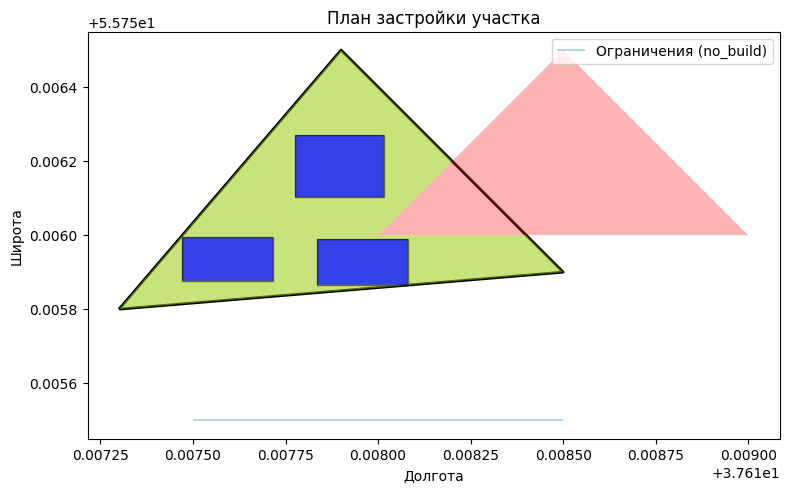

Изображение плана застройки сохранено как 'plan_zastroyki.png'.


In [12]:
fig, ax = plt.subplots(figsize=(8,8))

# Рисуем основную зону застройки
gpd.GeoSeries([zone_build]).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2, label="Зона застройки")

# Рисуем ограничивающие зоны
gpd.GeoSeries([restricted_union]).plot(ax=ax, facecolor="red", alpha=0.3, label="Ограничения (no_build)")

# Рисуем доступную территорию
gpd.GeoSeries([allowed_area]).plot(ax=ax, facecolor="green", alpha=0.3, label="Доступная территория")

# Рисуем здания
if buildings:
    gpd.GeoSeries(buildings).plot(ax=ax, facecolor="blue", alpha=0.7, edgecolor="k", label="Здания")

# Рисуем зону парка
gpd.GeoSeries([park_area]).plot(ax=ax, facecolor="yellow", alpha=0.3, label="Парк")

plt.legend()
plt.title("План застройки участка")
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.tight_layout()

# Сохраняем изображение в файл
plt.savefig("plan_zastroyki.png", dpi=300)
plt.show()

print("Изображение плана застройки сохранено как 'plan_zastroyki.png'.")